<a href="https://colab.research.google.com/github/HRiDOX/Dog-Breed-Prediction/blob/main/Dog_Breed_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Connecting collab with kaggle

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mdmahmudulhasanridoy","key":"e5835368544b7f2336c3453a32c42d53"}'}

In [3]:
!pip install -q kaggle

In [4]:
#The kaggle api client expects this file to be in ~/.kaggle, so move it there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json

#This permissions change avoids a warning on kaggle tool startup
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!mkdir dog_dataset
#changing directory to dog data set

%cd dog_dataset

/content/dog_dataset


In [6]:
#Searching for dataset in kaggle
!kaggle datasets list -s dogbreedidfromcomp


ref                                title                    size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------  ----------------------  -----  -------------------  -------------  ---------  ---------------  
catherinehorng/dogbreedidfromcomp  dog-breed-id-from-comp  691MB  2020-06-26 03:09:05           1681          6  0.1764706        


Searching Kaggle for required data set using search option(-s) with title 'dogbreedidfromcomp'.We can also use different search options like searching competions,notebooks,kernels,datasets etc


In [7]:
!kaggle datasets download catherinehorng/dogbreedidfromcomp
%cd ..

 99% 681M/691M [00:10<00:00, 88.8MB/s]
100% 691M/691M [00:10<00:00, 68.9MB/s]
/content


In [ ]:
# Unzipping downloaded file and removing unusable file
!unzip dog_dataset/dogbreedidfromcomp.zip -d dog_dataset
!rm dog_dataset/dogbreedidfromcomp.zip
!rm dog_dataset/sample_submission.csv

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from keras.preprocessing import image
from keras import regularizers

from sklearn.preprocessing import  label_binarize
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPool2D
from tensorflow.keras.optimizers import Adam

In [10]:
#Read labels.csv fileand checking the shape and records

labels_all = pd.read_csv("dog_dataset/labels.csv")
print(labels_all.shape)
labels_all.head()

(10222, 2)


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [11]:
#Visualize the number of each breeds

breeds_all = labels_all["breed"]
breeds_counts = breeds_all.value_counts()
breeds_counts.head()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
Name: breed, dtype: int64

In [12]:
CLASS_NAMES = ['scottish_deerhound','maltese_dog','bernese_mountain_dog']
labels = labels_all[(labels_all['breed'].isin(CLASS_NAMES))]
labels = labels.reset_index()
labels.head()

,index,id,breed
0,9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
1,12,00693b8bc2470375cc744a6391d397ec,maltese_dog
2,79,01e787576c003930f96c966f9c3e1d44,scottish_deerhound
3,90,022b34fd8734b39995a9f38a4f3e7b6b,maltese_dog
4,118,02d54f0dfb40038765e838459ae8c956,bernese_mountain_dog


In [ ]:
#creating numpy matrix with zeros
X_data = np.zeros((len(labels),224,224,3),dtype='float32')
X_data

In [14]:
#One hot encoding
Y_data = label_binarize(labels['breed'],classes = CLASS_NAMES)
Y_data

array([[1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0]])

In [15]:
#Reading and converting image to numpy array and normalizing dataset
for i in tqdm(range(len(labels))):
  img = image.load_img('dog_dataset/train/%s.jpg' % labels['id'][i],target_size = (224,224))
  img = image.img_to_array(img)
  x = np.expand_dims(img.copy(),axis=0)
  X_data[i] = x / 255.0


#Printing train image and one hot encode shape & size
print('\nTrain Images shape: ',X_data.shape,' size: {:,}'.format(X_data.size))
print('One-hot encoded output shape: ',Y_data.shape, 'Size: {:,}'.format(Y_data.size))

100%|██████████| 357/357 [00:01<00:00, 248.65it/s]


Train Images shape:  (357, 224, 224, 3)  size: 53,738,496
One-hot encoded output shape:  (357, 3) Size: 1,071


Here in output 357 is total image number and 224*224 is size and 3 means rgb (color effect)

Next we will create a network architecture for the model. We have used different types of layers according to their features namely Cpnv_2D(It is used to create a convolutional kernel that us convolved with the input layer to produce the output tensor),maxx_pooling2d(it is a downsampling technique which takes out the maximum valye over the window defined by poolsize),flatten(It flattens the input and creates 1D outptu),Dense(Dense layer produce the output as the dot product of input and kernel)

In [16]:
#Building the model
model = Sequential() # taking the model as sequential

#in first layer we're taking Conv2D
#After that we're taking MaxPool2D as it finds the most dominant feature in 2by2 matrix

model.add(Conv2D(filters = 64, kernel_size = (5,5), activation = 'relu', input_shape = (224,224,3)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (3,3),activation = 'relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 16, kernel_size = (7,7), activation = 'relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 16, kernel_size=(5,5), activation = 'relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128,activation = "relu", kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(64,activation = "relu", kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(len(CLASS_NAMES), activation = "softmax"))

model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0001),metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 108, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 16)        25104     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 16)       0

In [17]:
#After defining the network architecture we found out the total parameters as 268,227
#After defining the training data set into trainign and validation data sets
#Splitting the data set into training and testing data sets
X_train_and_val, X_test, Y_train_and_val, Y_test = train_test_split(X_data, Y_data, test_size = 0.1)
#Splitting the training data set into training and validation data set
X_train, X_val, Y_train, Y_val = train_test_split(X_train_and_val, Y_train_and_val, test_size = 0.2)

Now we will train our model on 100 epochs and a bacth size of 128. You can try using mode numbers of eopchs to increse accuracy .During each epochs we will see how  the model is performing by viewing the training  and validation accuracy

In [ ]:
#Traing the model

epochs = 100
batch_size = 128
history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
                    validation_data = (X_val, Y_val))

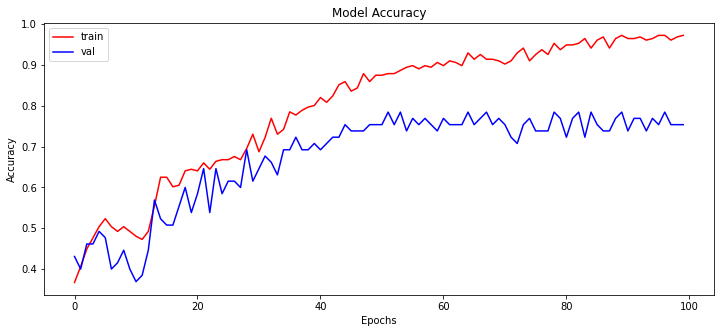

In [20]:
#Plot the training story

plt.figure(figsize=(12,5))
plt.plot(history.history['accuracy'],color='r')
plt.plot(history.history['val_accuracy'],color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train','val'])

plt.show()

Here we analyse how the model is learning with each epoch in terms of accuracy.

In [21]:
#We will use predict function to make the predictions using this model also we are finding out the accuracy of the test set.
Y_pred = model.predict(X_test)
score = model.evaluate(X_test,Y_test)
print('Accuracy over the test set: \n', round((score[1]*100),2),'%')

2/2 [==============================] - 1s 163ms/step - loss: 3.2145 - accuracy: 0.7778
Accuracy over the test set: 
 77.78 %


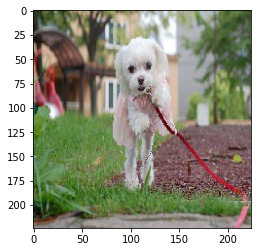

Original :  maltese_dog
Predicted :  maltese_dog


In [24]:
#Plottingimage to compare

plt.imshow(X_test[1,:,:,:])
plt.show()

#Finding the value from  prediction list and comparing original values with predicted values
print("Original : ",labels['breed'][np.argmax(Y_test[1])])
print("Predicted : ",labels['breed'][np.argmax(Y_pred[1])])

In [25]:
model.save("dog_breed.h5")